In [2]:
from math import sin, cos, tan, atan, atan2, sqrt, pi, radians, degrees, fabs
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import numpy as np

1. Código

In [3]:
# === Constantes globales ===
R_earth = 6378.1  # km
GM = 398600.4405  # km^3/s^2
a = 1.30262 * R_earth  # semi-eje mayor en km
e = 0.16561
omega_deg = 15  # grados
omega = radians(omega_deg)  # radianes

# Tiempo de paso por el pericentro (tp)
tp = Time("2025-03-31 00:00:00", scale='utc')

# === Función auxiliar: resolver la Ecuación de Kepler ===
def solve_kepler(l, e, tol=1e-10, max_iter=100):
    """Resuelve E - e*sin(E) = l usando el método de Newton-Raphson"""
    E = l  # suposición inicial
    for _ in range(max_iter):
        f = E - e * sin(E) - l
        df = 1 - e * cos(E)
        E_new = E - f / df
        if abs(E_new - E) < tol:
            return E_new
        E = E_new
    raise RuntimeError("No convergió al resolver la ecuación de Kepler")

# === Conversiones entre anomalías ===
def eccentric_to_true(E, e):
    """Convierte anomalía excéntrica E a anomalía verdadera f"""
    return 2 * atan2(sqrt(1 + e) * sin(E / 2), sqrt(1 - e) * cos(E / 2))

def mean_anomaly(t, tp, a):
    """Calcula la anomalía media l"""
    dt = (t - tp).sec
    n = sqrt(GM / a**3)
    return n * dt

# === Función position(t) ===
def position(t):
    if isinstance(t, str):
        t = Time(t, scale='utc')
    l = mean_anomaly(t, tp, a)
    E = solve_kepler(l, e)
    f = eccentric_to_true(E, e)
    phi = f + omega
    r = a * (1 - e**2) / (1 + e * cos(f))
    return r, degrees(phi % (2 * pi))

# === Función orbit() ===
def orbit():
    # Tiempos a lo largo de una órbita completa
    times = TimeDelta(np.linspace(0, 2 * pi * sqrt(a**3 / GM), 500), format='sec') + tp
    coords = [position(t) for t in times]
    r_vals, phi_vals = zip(*coords)
    phi_vals_rad = [radians(phi) for phi in phi_vals]
    
    # Conversión a coordenadas cartesianas
    x_vals = [r * cos(phi) for r, phi in zip(r_vals, phi_vals_rad)]
    y_vals = [r * sin(phi) for r, phi in zip(r_vals, phi_vals_rad)]

    # === Calcular el perihelio ===
    r_peri, phi_peri_deg = position(tp)
    phi_peri_rad = radians(phi_peri_deg)
    x_peri = r_peri * cos(phi_peri_rad)
    y_peri = r_peri * sin(phi_peri_rad)

    # === Gráfica ===
    plt.plot(x_vals, y_vals, label="Órbita del satélite")
    plt.plot(0, 0, 'yo', label="Tierra")
    plt.plot(x_peri, y_peri, 'r*', markersize=10, label="Pericentro")  # pericentro

    plt.axis('equal')
    plt.xlabel("x (km)")
    plt.ylabel("y (km)")
    plt.title("Órbita satelital")
    plt.grid()
    plt.legend(loc='upper right', fontsize='small') 
    plt.show()

def quadraticInterpolation(x1, x2, x3, f1, f2, f3, x):
    p2 = (((x - x2) * (x - x3)) / ((x1 - x2) * (x1 - x3))) * f1 + \
         (((x - x1) * (x - x3)) / ((x2 - x1) * (x2 - x3))) * f2 + \
         (((x - x1) * (x - x2)) / ((x3 - x1) * (x3 - x2))) * f3
    return p2

# === Función date(r0) ===
def date(r0):
    T = 2 * pi * sqrt(a**3 / GM)  # período orbital en segundos
    times = TimeDelta(np.linspace(0, 2 * pi * sqrt(a**3 / GM), 500), format='sec') + tp
    radii = [position(t)[0] for t in times]

    for i in range(len(radii) - 2):
        r1, r2, r3 = radii[i], radii[i+1], radii[i+2]
        if min(r1, r2, r3) <= r0 <= max(r1, r2, r3):
            t1, t2, t3 = times[i], times[i+1], times[i+2]
            x1 = (t1 - tp).sec
            x2 = (t2 - tp).sec
            x3 = (t3 - tp).sec
            a_, b_ = x1, x3
            for _ in range(100):
                m = (a_ + b_) / 2
                if abs(quadraticInterpolation(x1, x2, x3, r1, r2, r3, m) - r0) < 1e-6:
                    break
                if (quadraticInterpolation(x1, x2, x3, r1, r2, r3, a_) - r0) * (quadraticInterpolation(x1, x2, x3, r1, r2, r3, m) - r0) < 0:
                    b_ = m
                else:
                    a_ = m

            t_interp = tp + TimeDelta(m, format='sec')
            return t_interp.iso

    return None

2. Verificación position(t)

In [4]:
r_check, phi_check = position("2025-04-01 00:00:00")
print(f"r(t)={r_check:.3f} km      φ(t)={phi_check:.3f}")

r(t)=9658.409 km      φ(t)=185.597


3. Gráfico orbit()

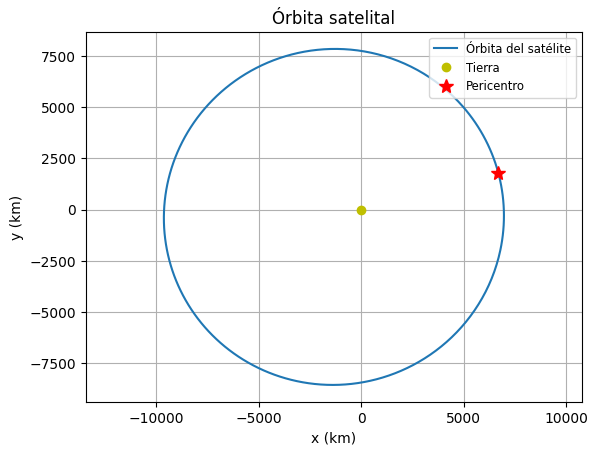

In [5]:
orbit()

4. Verificación función date(r0)

In [6]:
date(1.5*R_earth)

'2025-03-31 00:53:09.855'